# Products Matching

### There is three main issues:
1. Find the most k importent chars for every product (for our case k is 50) and build a query for sreach in alibaba website
2. Measure the similarity between amazon product and the results we get from the query
3. Decide for threshold that point for matching products

For the first point i use the df-idf algorithem for every product title. <br>
With this algorithm we can understand the most importent words from every title and build a good query that represent this product

In [1]:
import json
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import time
from typing import List

%matplotlib inline 

C:\Users\Latitude e7470\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
#Args
DATA_FOLDER = "resources"
FILENAME = "amazon_items.json"
K = 50

In [3]:
with open(os.path.join(DATA_FOLDER, FILENAME), "r", encoding="utf8") as f:
    products_data = json.load(f)

##### Build our tf-idf
For our tf-idf we will use only the product title as document except products with title length smaller that k (then add the description for the document).<br> This because i found that some column (like description) contains words that can confuse our query.<br>
In addition, we should delete the stop words from our documents (only for the tf-idf algo)

Because there is some other languege (not english) in our text i also use googletrans for ranslate those products

In [4]:
# !pip install --upgrade --force-reinstall googletrans==4.0.0-rc1
import googletrans
googletrans.__version__

'4.0.0-rc.1'

Example for product title in 'de'

In [6]:
from googletrans import Translator
translator = Translator()
print(translator.detect("Anzuchtschalen, weiss").lang)
print(translator.translate("Anzuchtschalen, weiss").text)

de
Middle shells, white


In [7]:
docs = []

for key in tqdm(products_data.keys()):
    time.sleep(1)
    title = products_data[key]["title"]
    if translator.detect(title).lang != 'en':
        title = translator.translate(title).text
    if len(title) < K:
        title = title + translator.translate(products_data[key]['description']).text
    docs.append({"doc_id": key, "title": title})
df_docs = pd.DataFrame(docs)
df_docs.head()

100%|██████████| 374/374 [08:36<00:00,  1.40s/it]


,doc_id,title
0,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro..."
1,B06XG2QYX9,Wireless Security Camera with Two-way Audio - ...
2,B07BR3F9N6,Comgrow Creality Ender 3 3D Printer Fully Open...
3,B07FT8JS93,Cervical Pillow Contour Pillow for Neck and Sh...
4,B07S5F92V8,"Sivio Weighted Blanket for Kids(5lbs, 36 x48 I..."


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(df_docs.title.tolist()).toarray()
all_words_from_documents = vectorizer.get_feature_names_out()

In [9]:
vectorizer.get_feature_names_out()

array(['00', '000', '00016a', ..., 'zitahli', 'zoom', 'zuckeo'],
      dtype=object)

##### Find the query for every product and create Dataframe 

In [10]:
# Lets assume that every word habe at least 2 chars
def find_most_k_importent_char(x_vector: np.ndarray, all_words_from_documents: np.ndarray, k: int = 50):
    num_words = k // 2
    ind = np.argpartition(x_vector, -num_words)[-num_words:]
    indexes = ind[np.argsort(x_vector[ind])][::-1]
    most_significant_words = all_words_from_documents[indexes]
    query = ""
    for i, word in enumerate(most_significant_words):
        if len(f"{query} {word}") <= k:
            query += f"{word} "
        else:
            best_indexes = indexes[:i]
            best_words = most_significant_words[:i]
            return query[:-1]

In [11]:
qurey_results = [find_most_k_importent_char(X[i], all_words_from_documents, K) for i, doc in enumerate(df_docs.title)]

In [12]:
df_docs['doc_query'] = qurey_results

In [13]:
df_docs.head()

,doc_id,title,doc_query
0,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v
1,B06XG2QYX9,Wireless Security Camera with Two-way Audio - ...,security camera kamtron surveillance ip audio two
2,B07BR3F9N6,Comgrow Creality Ender 3 3D Printer Fully Open...,220x220x250mm resume ender creality fully source
3,B07FT8JS93,Cervical Pillow Contour Pillow for Neck and Sh...,pillow sleepers neck coisum pillowcase cervical
4,B07S5F92V8,"Sivio Weighted Blanket for Kids(5lbs, 36 x48 I...",weighted blanket sivio 5lbs x48 36 beads toddler


In [14]:
df_docs[df_docs.doc_id == 'B01LX0JBUU']

,doc_id,title,doc_query
140,B01LX0JBUU,"Middle shells, whiteWith drain hole at bottom ...",roots cell size 10 base tray humidity seed reduce


In [16]:
def check_query_size(queries: List[str], k: int):
    for q in queries:
        assert len(q) <= k
check_query_size(df_docs.doc_query, K)

#### Measure the similarity between products with SentenceBert
SentenceBert is model the trained for similarity task berween documents

In [17]:
#!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

Get all products that we finding with our query for each item from amazon. <br>
Build new DataFrame with the return products from the searching

In [19]:
from resources.alibaba_search import alibaba_get_search_result_titles
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
def search_query(q):
    search_result = alibaba_get_search_result_titles(q)
    alibaba_products, alibaba_url = [], []
    for ali_product, ali_url in search_result.values():
        alibaba_products.append(ali_product)
        alibaba_url.append(ali_url)
    return alibaba_products, alibaba_url

In [22]:
search_results = {"doc_id": [], "title": [], "doc_query": [], "alibaba_product": [], "alibaba_url":[], "cosine_similarity": []}
for doc_id, title, q in tqdm(df_docs.values):
    alibaba_products, alibaba_url = search_query(q)
    products_to_compare = [title] + alibaba_products
    sentence_embeddings = model.encode(products_to_compare)
    products_similarity = cosine_similarity([sentence_embeddings[0, :]], sentence_embeddings[1:, :])
    search_results["doc_id"] += [doc_id] * len(alibaba_products)
    search_results["title"] += [title] * len(alibaba_products)
    search_results["doc_query"] += [q] * len(alibaba_products)
    search_results["alibaba_product"] += alibaba_products
    search_results["alibaba_url"] += alibaba_url
    search_results["cosine_similarity"] += list(products_similarity[0])

100%|██████████| 374/374 [23:44<00:00,  3.81s/it]


In [23]:
df_similarity = pd.DataFrame(search_results)
df_similarity.head()

,doc_id,title,doc_query,alibaba_product,alibaba_url,cosine_similarity
0,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v,Ir Led Light Strip Led Amazon 44Keys IR Wifi W...,//www.alibaba.com/product-detail/Ir-Led-Light-...,0.792979
1,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v,Led Keys Ir Strip 12vled 5050 Rgb Led Strip LE...,//www.alibaba.com/product-detail/Led-Keys-Ir-S...,0.805444
2,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v,Linkable connect IP65 LED clone Grow Light fix...,//www.alibaba.com/product-detail/Linkable-conn...,0.630047
3,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v,32.8ft 5M RGB LED Strip Lights full Kit/set 50...,//www.alibaba.com/product-detail/32-8ft-5M-RGB...,0.818303
4,B07T9K4XKN,"Led Strip Lights 32.8ft, GOADROM IP65 Waterpro...",lights goadrom 300 keys strips ir 44 led 8ft 12v,Led Strip Key Led Rgb Led Light Strip Amazon S...,//www.alibaba.com/product-detail/Led-Strip-Key...,0.688432


In [24]:
df_similarity.shape

(8976, 6)

#### Finding the threshold
For the threshold we can do several on things:
1. Guess (not recommended :))
2. Take care of labeling some of the data and try to learn from it
3. Try to find an interesting point by visualization

I try to combine point 3 and 2

Pick 50 random products

In [74]:
random_products = np.random.choice(pd.unique(df_similarity.doc_id), 50)

In [75]:
df_random_products = df_similarity[df_similarity.doc_id.isin(random_products)]

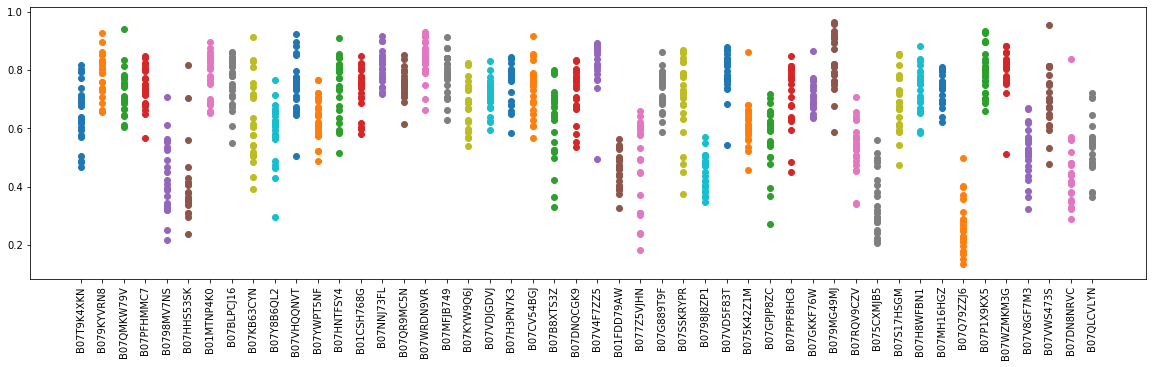

In [76]:
fig, ax = plt.subplots(figsize=(20,5))
for d in pd.unique(df_random_products.doc_id):
    df = df_random_products[df_random_products.doc_id == d]
    plt.scatter(df.doc_id, df.cosine_similarity)
_ = plt.xticks(rotation=90)

In this picture you can find interesting distributions of the results.<br>
You can see that there are some products that are in the lower part in terms of confidence and some in the upper part with high confidence. <br>
If we take some products from the edges of confidence (his confidence product is below and a product whose confidence is above) we can understand where our confidence intersection point is. <br>
In our case after check the confidence score 0.8 look promise. So i check this confidence in some product and found some conclusions:
1. Confidence score less that 0.6 is probably not this product
2. Confidence between 0.6 and 0.8 is probably similarity product
3. Confidence that bigger than 0.8 is probably machong product

Now, Lets generate the matching products from alibaba for each amazon product

In [77]:
df_similarity[df_similarity.cosine_similarity >= 0.8].sort_values("doc_id")

,doc_id,title,doc_query,alibaba_product,alibaba_url,cosine_similarity
5696,B00MMRFQR6,"Midea WHS-87LSS1 Refrigerator, 2.4 Cubic Feet,...",whs midea 87lss1 cubic feet refrigerator steel,Smad Home Use Side by Side Door Large Capacity...,//www.alibaba.com/product-detail/Smad-Home-Use...,0.865550
5690,B00MMRFQR6,"Midea WHS-87LSS1 Refrigerator, 2.4 Cubic Feet,...",whs midea 87lss1 cubic feet refrigerator steel,Refrigerator 100L Combi Fridge Double Door Ref...,//www.alibaba.com/product-detail/Refrigerator-...,0.839906
5693,B00MMRFQR6,"Midea WHS-87LSS1 Refrigerator, 2.4 Cubic Feet,...",whs midea 87lss1 cubic feet refrigerator steel,18Cuft Stainless Steel No Frost Double Door Re...,//www.alibaba.com/product-detail/18Cuft-Stainl...,0.817647
5711,B00MMRFQR6,"Midea WHS-87LSS1 Refrigerator, 2.4 Cubic Feet,...",whs midea 87lss1 cubic feet refrigerator steel,Stainless Steel 18cuft 510L Frost-free Double ...,//www.alibaba.com/product-detail/Stainless-Ste...,0.809502
5710,B00MMRFQR6,"Midea WHS-87LSS1 Refrigerator, 2.4 Cubic Feet,...",whs midea 87lss1 cubic feet refrigerator steel,Smeta 545L No Frost Top Freezer Stainless Stee...,//www.alibaba.com/product-detail/Smeta-545L-No...,0.821940
...,...,...,...,...,...,...
2310,B081SVY2M4,Selfie Ring Light with Tripod Stand and Phone ...,steaming ring vlogging halo photography selfie,Selfie Ring Tripod Stand Phone Holder LED Circ...,//www.alibaba.com/product-detail/Selfie-Ring-T...,0.939506
2309,B081SVY2M4,Selfie Ring Light with Tripod Stand and Phone ...,steaming ring vlogging halo photography selfie,USAMS ZB209 New Fashion Portable Adjust Foldab...,//www.alibaba.com/product-detail/USAMS-ZB209-N...,0.834640
2308,B081SVY2M4,Selfie Ring Light with Tripod Stand and Phone ...,steaming ring vlogging halo photography selfie,Selfie Ring Photography Led Light With Tripod ...,//www.alibaba.com/product-detail/Selfie-Ring-P...,0.883884
2314,B081SVY2M4,Selfie Ring Light with Tripod Stand and Phone ...,steaming ring vlogging halo photography selfie,UBeesize 10 inch LED Ring Light with Stand and...,//www.alibaba.com/product-detail/UBeesize-10-i...,0.833414
